In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed
from lowda import load_galaxy
import lowda as lwd

In [2]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [4]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [5]:
snapnum = 40
z = meta['redshift'][snapnum]
tuniv = meta['time'][snapnum]

print('snapnum=', snapnum)
print('z=', z)
print('tuniv=', tuniv)

snapnum= 40
z= 1.4955121664955557
tuniv= 4.292907980150009


In [6]:
subID = 172175
MDB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMDB=True)

In [14]:
for k in MDB.keys():
    if MDB[k].shape == MDB['SnapNum'].shape:
        print(k, MDB[k][0])

DescendantID -1
FirstProgenitorID 146896549
FirstSubhaloInFOFGroupID 146896548
GroupBHMass 0.035397273
GroupBHMdot 0.00026960552
GroupFirstSub 392276
GroupGasMetallicity 0.0063437503
GroupLen 17802778
GroupMass 386.20435
GroupNsubs 2345
GroupSFR 8.183293
GroupStarMetallicity 0.021114947
GroupWindMass 0.009473496
Group_M_Crit200 268.08185
Group_M_Crit500 174.77962
Group_M_Mean200 336.63205
Group_M_TopHat200 307.354
Group_R_Crit200 225.93253
Group_R_Crit500 144.34335
Group_R_Mean200 360.56927
Group_R_TopHat200 295.625
LastProgenitorID 147022639
MainLeafProgenitorID 146896647
Mass 197.65404
MassHistory 9164.606
NextProgenitorID -1
NextSubhaloInFOFGroupID 147022640
NumParticles 6430540
RootDescendantID 146896548
SnapNum 99
SubfindID 392276
SubhaloBHMass 0.019873647
SubhaloBHMdot 1.4251465e-05
SubhaloGasMetallicity 0.012886952
SubhaloGasMetallicityHalfRad 0.018185813
SubhaloGasMetallicityMaxRad 0.0
SubhaloGasMetallicitySfr 0.012008177
SubhaloGasMetallicitySfrWeighted 0.012058863
SubhaloGrNr

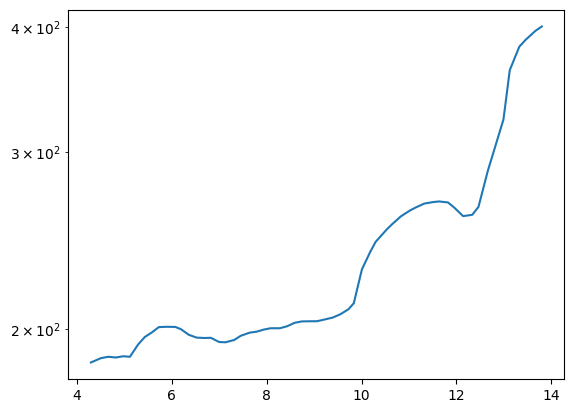

In [17]:
time = meta['time'][MDB['SnapNum']]
plt.plot(time, MDB['Group_M_Crit200']/0.67)
plt.yscale('log')

In [23]:
h = meta['header'][99].HubbleParam
print('M200=', MDB['Group_M_Crit200'][0]/h)

M200= 395.7511782470199


In [21]:
h = meta['header'][99].HubbleParam

0.6774

In [24]:
subID = 392276
snapnum = 99
fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)

In [39]:
r = np.linalg.norm(snap['Coordinates'] - sub['SubhaloPos'], axis=1)
in_2rhalf = r < 6*sub['SubhaloHalfmassRadType'][4]
print(np.sum(snap['Masses'][in_2rhalf])/h)

7.990156967167591
